## Zindi Spot the Mask Challenge


The objective of this challenge is to create an image classification machine learning model to accurately predict the likelihood that an image contains a person wearing a face mask, or not. The total dataset contains 1,800+ images of people either wearing masks or not.

> https://zindi.africa/competitions/zindiweekendz-learning-spot-the-mask-challenge/data

In [ ]:
# Install necessary packages and import data
! pip install -q torch
! pip install fastai
! pip install timm
! pip install nbdev
! cp /content/drive/MyDrive/zindi_mask_challenge.zip /content/
! unzip zindi_mask_challenge.zip

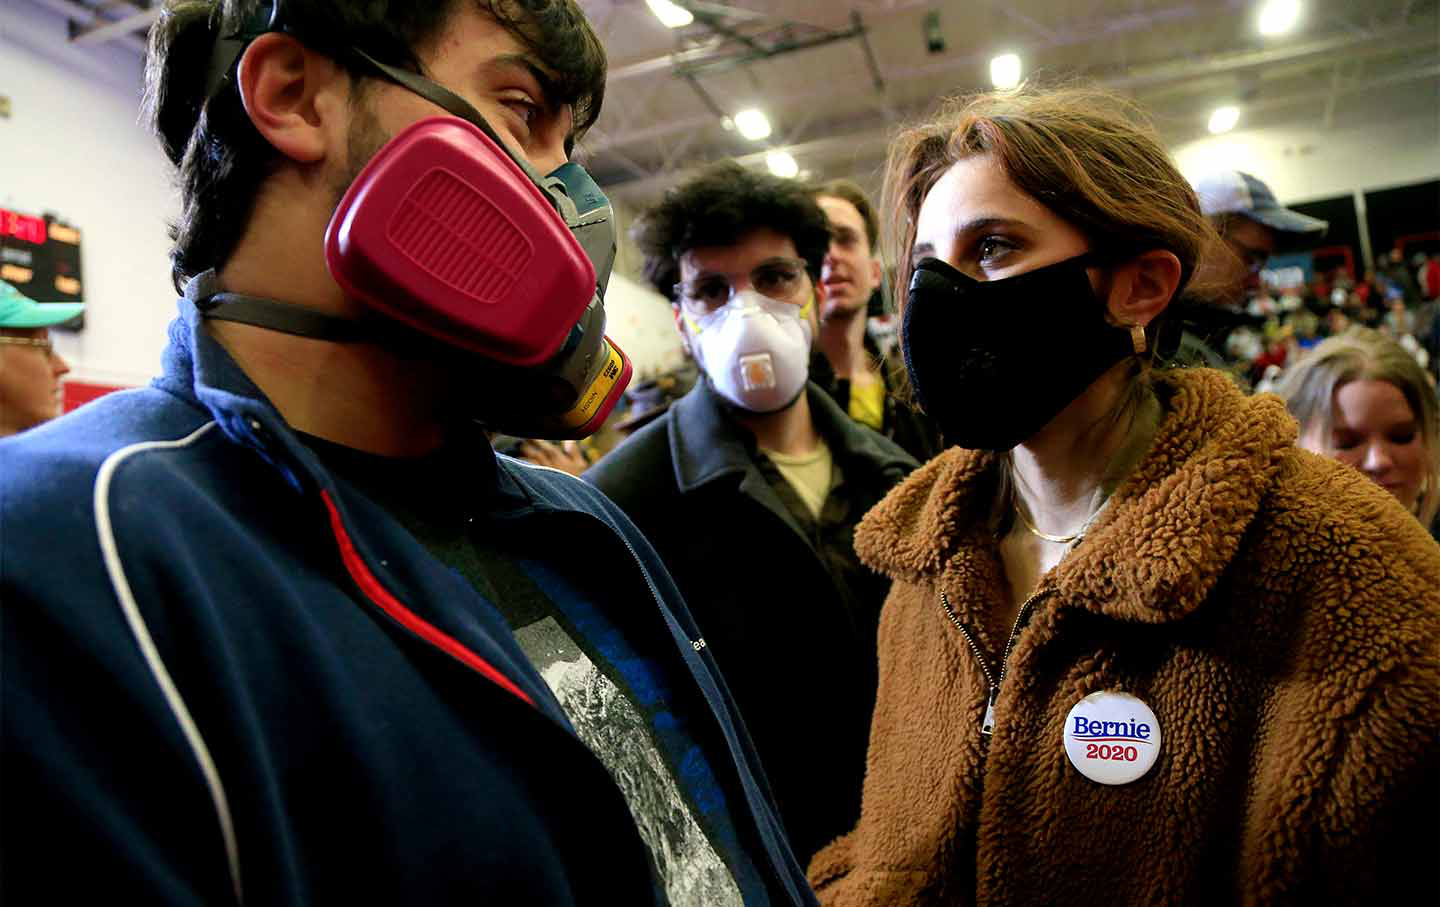

In [1]:
# Import necessary packages 
import torch
import fastai
import nbdev
import timm
from fastai.vision.all import*

# Define paths/files
path = Path()
train_path = path / 'zindi_mask_challenge' / 'train_images'
train_files = get_image_files(train_path)

# Create image
img = PILImage.create(train_files[300])
img

In [36]:
max(img.size)

600

In [23]:
image_size = []

for count, img in enumerate(train_files):
  image_size.append([PILImage.create(img).size])

Images have different dimensions. What would be the best way to go about this?

## Data Augmentation

Data augmentation refers to creating random variations of our input data, such that they appear different but do not change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes, and contrast changes. This is typically passed to the data loader and applied to all images in a batch.

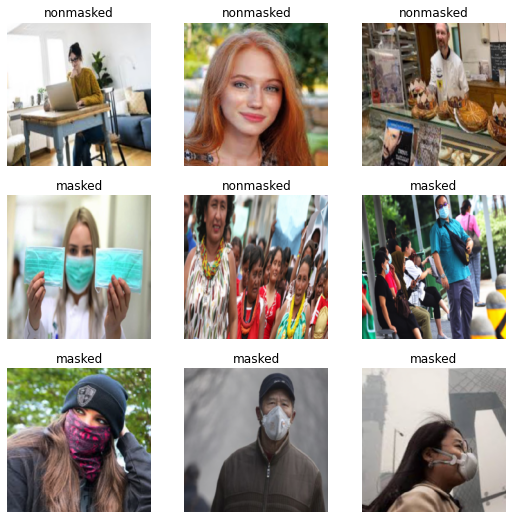

In [2]:
# Preprocess images
dls = ImageDataLoaders.from_folder(train_path, valid_pct = 0.2, item_tfms = Resize(size = 480, method = "squish"),
                                   batch_tfms=(aug_transforms(size = 224, min_scale=0.75)))

# Display transformed images
dls.show_batch(
    #unique = True
    )

In [40]:
aug_transforms(size = 224, min_scale=0.75)

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'max_scale': 1.0, 'mode_mask': 'nearest', 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorMask,object) -> encodes
 decodes: ]

> RandomResizedCropGPU: At each epoch, a random part of the image is selected and cropped. Hence model will learn to focus on, and recognize, different features in our images.

## Create model

Try out a convnext first

In [47]:
import timm
timm.list_models("convnext*")

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_hnf',
 'convnext_nano_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [3]:
dls.vocab

['masked', 'nonmasked']

In [4]:
# Stack preprocessor and model arch and evaluation metrics
workflow = vision_learner(dls = dls, arch = 'convnext_small_in22k', metrics=accuracy).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


## Train/fine tune

In [5]:
workflow.fine_tune(epochs = 12, base_lr = 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.330236,0.388555,0.973180,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.069058,0.269264,0.977012,00:27
1,0.067572,0.293079,0.980843,00:26
2,0.059535,0.300123,0.977012,00:25
3,0.059313,0.112964,0.980843,00:25
4,0.047542,0.166096,0.980843,00:25
5,0.034606,0.212845,0.980843,00:26
6,0.033537,0.187676,0.977012,00:25
7,0.027632,0.199473,0.973180,00:24
8,0.030884,0.215805,0.969349,00:24
9,0.023241,0.200598,0.984674,00:26


Here's how we would replicat the last result on the **validation set**

In [ ]:
probs, targs = workflow.get_preds(dl = dls.valid)
accuracy(probs, targs)

One thing to note is that on the training set, the crop area is chosen randomly. On the validation set, the center square of the image is always chosen. This center cropping could be problematic since the model could miss some important aspects of the image during inference. One solution is to use Test Time Augmentation. In this technique during inference, multiple versions of the image are created and then the average/maximum of the predictions are taken. Depending on the dataset, test time augmentation can result in dramatic improvements in accuracy. Let's see whether this would work in our case:

In [10]:
probs, targs = workflow.tta(dl = dls.valid)
accuracy(probs, targs)

TensorBase(0.9847)

Almost the same...

## Make prediction on test set

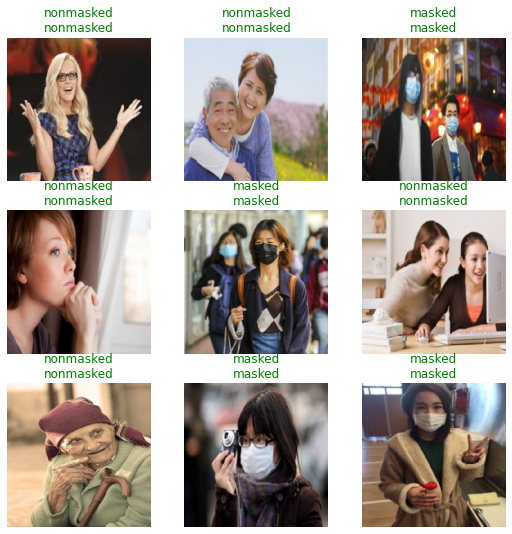

In [15]:
# Test items
test_files = get_image_files(path / 'zindi_mask_challenge' / 'test_images')
test_files.sort()

# Test data loader
test_dl = dls.test_dl(test_files)

# Make predictions on test images
probs, targs = workflow.tta(dl = test_dl)

# Show results
workflow.show_results()

## Prepare for submission

In [25]:
dict(enumerate(dls.vocab))

{0: 'masked', 1: 'nonmasked'}

We were predicting whether a person was masked. Hence loss = 1-prediction?

In [30]:
probs

TensorBase([[3.7461e-01, 6.2539e-01],
            [1.2663e-09, 1.0000e+00],
            [1.0000e+00, 1.4919e-10],
            ...,
            [1.6607e-07, 1.0000e+00],
            [1.0000e+00, 6.2496e-08],
            [7.6255e-06, 9.9999e-01]])

In [40]:
import pandas as pd
from google.colab import files
sub_preds = probs[:, 1].numpy()
ss = pd.read_csv("/content/zindi_mask_challenge/SampleSubmission.csv")
ss["target"] = sub_preds
ss.to_csv("mask_sub_01.csv", index=False)
files.download("mask_sub_01.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
! head "mask_sub_01.csv"

image,target
aadawlxbmapqrblgxyzarhjasgiobu.png,0.6253896
abpxvdfyhaaohzcrngcucmhffwizxs.jpg,1.0
aclkjfvackiieiznzfcwienplielrj.jpg,1.4919464e-10
aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,2.2649962e-09
aelzzshpfxerelefnkatpczktuxjln.jpg,0.99999994
ajnjnkvstqesvfohaptobyasrkmcnq.jpg,0.9999997
akkydnvilgvzigllmboonbqbbioocs.jpg,2.6866043e-10
akvjfjhgayyjwrqrczjbeyoqhhajis.jpg,0.99997723
alcveyvosnywyjbmngolmnblftdoje.jpg,1.0


In [ ]:
sub_preds

In [14]:
test_files

(#509) [Path('zindi_mask_challenge/test_images/aadawlxbmapqrblgxyzarhjasgiobu.png'),Path('zindi_mask_challenge/test_images/abpxvdfyhaaohzcrngcucmhffwizxs.jpg'),Path('zindi_mask_challenge/test_images/aclkjfvackiieiznzfcwienplielrj.jpg'),Path('zindi_mask_challenge/test_images/aelkivmayxgsdjosiibfgmkvfrjvjk.jpg'),Path('zindi_mask_challenge/test_images/aelzzshpfxerelefnkatpczktuxjln.jpg'),Path('zindi_mask_challenge/test_images/ajnjnkvstqesvfohaptobyasrkmcnq.jpg'),Path('zindi_mask_challenge/test_images/akkydnvilgvzigllmboonbqbbioocs.jpg'),Path('zindi_mask_challenge/test_images/akvjfjhgayyjwrqrczjbeyoqhhajis.jpg'),Path('zindi_mask_challenge/test_images/alcveyvosnywyjbmngolmnblftdoje.jpg'),Path('zindi_mask_challenge/test_images/alfuzzlrjkdrrzauiswqnuvpvzfluc.jpg')...]